In [1]:
# from kan import *
from efficient_kan import KAN
import matplotlib.pyplot as plt
import pandas as pd
import argparse
import numpy as np
import os
from copy import deepcopy
from tqdm.auto import tqdm
from dataloaders.dataloader import FCMatrixDataset
from utils import balanced_random_split_v2


import wandb
import yaml

from torch.utils.data import Dataset, DataLoader, Subset
from torch.utils.data.dataset import random_split
from torch.utils.data.sampler import SubsetRandomSampler

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix


import torch
import torch.nn as nn
import torch.nn.functional as func
import torch.optim as optim

from copy import deepcopy
from functools import partial

/home/ljdevries/.conda/envs/pykan-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = "cpu"


In [7]:
batch_size = 48
n_epochs = 25
hidden_dims = [256,64]
lr = 0.00007697
mrmr = False
lamb = 0.1
lamb_entropy = 2.0
grid_size = 3

# batch_size = 48
# n_epochs = 25
# hidden_dims = [128]
# lr = 0.000769
# mrmr = True
# weight_decay = 0.001

In [8]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=99)

if mrmr is True:
	input_features = 55
	mrmr_features = np.array([1140, 536, 223, 907, 1449, 499, 1293, 45, 135, 1440, 879, 1384, 1210, 1316, 122, 22, 492, 638, 765, 1027, 1464, 501, 1462, 395, 26, 1079, 70, 425, 1403, 1409, 1318, 886, 1459, 1448, 939, 1163, 547, 10, 413, 676, 131, 216, 942, 1136, 1386, 232, 1455, 1337, 814, 139, 392, 1376, 1382, 471, 656]
	)
# smith moderate features
# mrmr_features = np.array([922, 135, 956, 867, 589, 1308, 55, 426, 1483, 466, 1023, 1324, 1327, 902, 1391, 981, 200, 275, 871, 1122, 1314, 590, 934, 629, 952, 421, 538, 762, 378, 1053, 865, 418, 948, 462, 248, 646, 944, 485, 539, 1269, 407, 879, 1027, 782, 1449, 1421, 1360, 550, 1257, 415, 681, 1147, 89, 664, 163]
#                          )
else:
	input_features = 1485
	mrmr_features = None

dims = [input_features] + hidden_dims + [2]

ds = "data/csv/severe_rds.csv"
# ds = "data/csv/balanced_sex_classification.csv"
data_dir = "data/fetched/25751/raw"
udi = "25751"

dataset = FCMatrixDataset(ds, data_dir, udi, mapping=None, mrmr=mrmr_features)
labels = np.genfromtxt(ds)
eids = labels[:,0]
labels = labels[:,1]
eval_metrics = np.zeros((skf.n_splits, 3))

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=99)


In [9]:
def KAN_train(model, loader):
    # model.train()

    loss_all = 0
    for data in loader:
        inputs = data[0].to(DEVICE)
        labels = data[1].to(DEVICE)

        optimizer.zero_grad()
        output = model(inputs)
       
        loss = func.cross_entropy(output, labels)
        loss.backward()
        loss_all += batch_size * loss.item()
        optimizer.step()
    return loss_all / len(train_dataset)


def KAN_test(model, loader):
    pred = []
    label = []
    loss_all = 0
    for data in loader:
        inputs = data[0].to(DEVICE)
        labels = data[1].to(DEVICE)

        output = model(inputs)
        loss = func.cross_entropy(output, labels)
        loss_all += batch_size * loss.item()
        # pred.append(func.softmax(output, dim=1).max(dim=1)[1])
        _, predicted = torch.max(output, 1)
        pred.append(predicted)
        label.append(labels)

    y_pred = torch.cat(pred, dim=0).cpu().detach().numpy()
    print(y_pred)
    y_true = torch.cat(label, dim=0).cpu().detach().numpy()
    print(y_true)
    tn, fp, fn, tp = confusion_matrix(y_pred, y_true).ravel()
    
    epoch_sen = tp / (tp + fn)
    # epoch_sen = 0
    epoch_spe = tn / (tn + fp)
    # epoch_spe = 0
    epoch_acc = (tn + tp) / (tn + tp + fn + fp)
    return epoch_sen, epoch_spe, epoch_acc, loss_all / len(val_dataset)


In [10]:
print(DEVICE)

for n_fold, (train_val, test) in enumerate(skf.split(labels, labels)):

    print(dims)

    model = KAN(dims, symbolic_enabled=False, device=DEVICE, bias_trainable=True, grid=grid_size)



    train_val_dataset, test_dataset = Subset(dataset, train_val), Subset(dataset, test)
    train_val_labels = labels[train_val]
    train_val_index = np.arange(len(train_val_dataset))

    train, val, _, _ = train_test_split(train_val_index, train_val_labels, test_size=0.11, shuffle=True, stratify=train_val_labels)
    train_dataset, val_dataset = Subset(train_val_dataset, train), Subset(train_val_dataset, val)

    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    def seperate_subset(subset):
        input = [subset[i][0] for i in range(len(subset))]
        input = torch.stack(input)
        label = [subset[i][1] for i in range(len(subset))]
        
        label = torch.stack(label)
        return input, label

    train_input, train_label = seperate_subset(train_dataset)
    val_input, val_label = seperate_subset(val_dataset)
    test_input, test_label = seperate_subset(test_dataset)

    # lr=.001

    datadict = {'train_input': train_input, 'train_label': train_label, 'val_input': val_input, 'val_label': val_label, 'test_input': test_input, 'test_label': test_label}
    results = model.train(datadict, opt="LBFGS", loss_fn=torch.nn.CrossEntropyLoss(), steps=n_epochs, lr=lr, lamb=lamb, lamb_entropy=lamb_entropy, update_grid=True, device=DEVICE)
    print(results['train_loss'])
    
    # print('CV: {:03d}, Epoch: {:03d}, Val Loss: {:.5f}, Val BAC: {:.5f}'.format(n_fold + 1, epoch + 1, min_v_loss, best_val_acc))
    
    test_sen, test_spe, test_acc, _ = KAN_test(model, test_loader)
    print('CV: {:03d}, SEN: {:.5f}, SPE: {:.5f}, ACC: {:.5f}'.format(n_fold + 1, test_sen, test_spe, test_acc))


    eval_metrics[n_fold, 0] = test_sen
    eval_metrics[n_fold, 1] = test_spe
    eval_metrics[n_fold, 2] = test_acc

eval_df = pd.DataFrame(eval_metrics)
eval_df.columns = ['SEN', 'SPE', 'ACC']
eval_df.index = ['Fold_%02i' % (i + 1) for i in range(skf.n_splits)]
print(eval_df)
print('Average Sensitivity: %.4f±%.4f' % (eval_metrics[:, 0].mean(), eval_metrics[:, 0].std()))
print('Average Specificity: %.4f±%.4f' % (eval_metrics[:, 1].mean(), eval_metrics[:, 1].std()))
print('Average Accuracy: %.4f±%.4f' % (eval_metrics[:, 2].mean(), eval_metrics[:, 2].std()))


cuda
[1485, 256, 64, 2]


description:   0%|                                                           | 0/25 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.13 GiB. GPU 

In [ ]:
test_sen, test_spe, test_acc, _ = KAN_test(model, test_loader)
test_acc
# model.save_ckpt("beruh")

[1 0 1 0 0 0 1 0 0 0 1 1 1 1 0 1 0 0 1 1 1 1 1]
[0 0 0 1 0 0 1 1 1 1 1 0 0 0 0 1 0 1 0 1 1 1 0]


0.4782608695652174

In [ ]:
model.load_ckpt("bruh")

dict_keys(['train_loss', 'test_loss', 'reg'])
[array(0.8325545, dtype=float32), array(0.83098894, dtype=float32), array(0.82926184, dtype=float32), array(0.8273321, dtype=float32), array(0.8251854, dtype=float32), array(0.8228206, dtype=float32), array(0.82025826, dtype=float32), array(0.8174521, dtype=float32), array(0.8143966, dtype=float32), array(0.8110871, dtype=float32), array(0.807537, dtype=float32), array(0.80376846, dtype=float32), array(0.79972804, dtype=float32), array(0.7954115, dtype=float32), array(0.7908151, dtype=float32), array(0.78595334, dtype=float32), array(0.78086317, dtype=float32), array(0.77548635, dtype=float32), array(0.76982147, dtype=float32), array(0.76386756, dtype=float32), array(0.7576442, dtype=float32), array(0.7512014, dtype=float32), array(0.74447674, dtype=float32), array(0.73747295, dtype=float32), array(0.7301933, dtype=float32)]


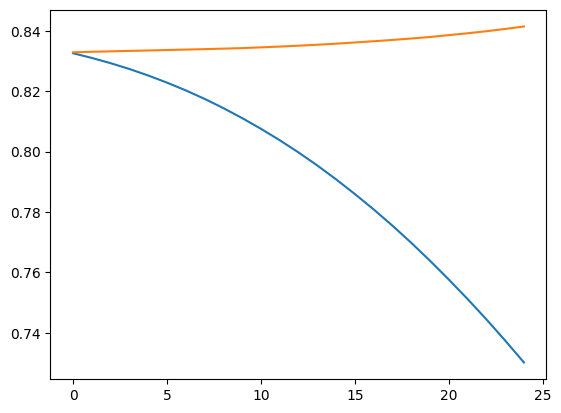

In [ ]:
print(results.keys())

print(results['train_loss'])

plt.plot(results['train_loss'])
plt.plot(results['test_loss'])
plt.show()

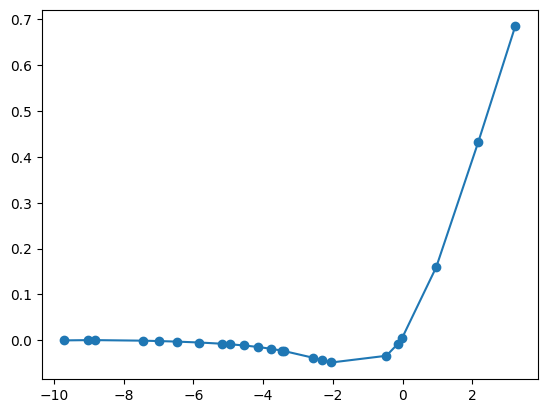

In [ ]:
preacts = model.spline_preacts[0]
postacts = model.spline_postacts[0]
i = 300
j = 0
inputs = preacts[:, j,i].detach().cpu().numpy()
outputs = postacts[:, j,i].detach().cpu().numpy()

rank = np.argsort(inputs)
inputs = inputs[rank]
outputs = outputs[rank]

plt.plot(inputs, outputs, marker='o')
plt.show()


In [ ]:

for n_fold, (train_val, test) in enumerate(skf.split(labels, labels)):

    model = KAN(dims).to(DEVICE)
    # model = FasterKAN(dims).to(DEVICE)
    # model = GCN(55, hidden_dims, 2, dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    ## OG CODE ##
    # train_val_dataset, test_dataset = dataset[train_val.tolist()], dataset[test.tolist()]
    # train_val_labels = labels[train_val]
    # train_val_index = np.arange(len(train_val_dataset))

    # train, val, _, _ = train_test_split(train_val_index, train_val_labels, test_size=0.11, shuffle=True, stratify=train_val_labels)
    # train_dataset, val_dataset = train_val_dataset[train.tolist()], train_val_dataset[val.tolist()]
    ## //OG CODE ##
    
    train_val_dataset, test_dataset = Subset(dataset, train_val), Subset(dataset, test)
    train_val_labels = labels[train_val]
    train_val_index = np.arange(len(train_val_dataset))

    train, val, _, _ = train_test_split(train_val_index, train_val_labels, test_size=0.11, shuffle=True, stratify=train_val_labels)
    train_dataset, val_dataset = Subset(train_val_dataset, train), Subset(train_val_dataset, val)
    # total_size = len(dataset)
    # train_size = int(0.8 * total_size)
    # val_size = int(0.1 * total_size)

    # test_size = total_size - train_size - val_size
    
    # train_dataset, val_dataset, test_dataset = balanced_random_split_v2(dataset, [train_size, val_size, test_size], num_classes=2)

    def seperate_subset(subset):
        input = [subset[i][0] for i in range(len(subset))]
        input = torch.stack(input)
        label = [subset[i][1] for i in range(len(subset))]
        label = torch.tensor(label)
        return input, label

    train_input, train_label = seperate_subset(train_dataset)
    val_input, val_label = seperate_subset(val_dataset)
    test_input, test_label = seperate_subset(test_dataset)

    datadict = {'train_input': train_input, 'train_label': train_label, 'val_input': val_input, 'val_label': val_label, 'test_input': test_input, 'test_label': test_label}



    model.train(datadict)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    print(len(train_dataset), len(val_dataset), len(test_dataset))

    min_v_loss = np.inf
    best_val_acc = 0
    for epoch in range(n_epochs):
        t_loss = KAN_train(model, train_loader)
        val_sen, val_spe, val_acc, v_loss = KAN_test(model, val_loader)

        if min_v_loss > v_loss:
        # if best_val_acc < val_acc:
            min_v_loss = v_loss
            best_val_acc = val_acc
            # best_model = deepcopy(model)
            best_model = model    
    print('CV: {:03d}, Epoch: {:03d}, Val Loss: {:.5f}, Val BAC: {:.5f}'.format(n_fold + 1, epoch + 1, min_v_loss, best_val_acc))
    
    test_sen, test_spe, test_acc, _ = KAN_test(best_model, test_loader)


    eval_metrics[n_fold, 0] = test_sen
    eval_metrics[n_fold, 1] = test_spe
    eval_metrics[n_fold, 2] = test_acc

eval_df = pd.DataFrame(eval_metrics)
eval_df.columns = ['SEN', 'SPE', 'ACC']
eval_df.index = ['Fold_%02i' % (i + 1) for i in range(skf.n_splits)]
print(eval_df)
print('Average Sensitivity: %.4f±%.4f' % (eval_metrics[:, 0].mean(), eval_metrics[:, 0].std()))
print('Average Specificity: %.4f±%.4f' % (eval_metrics[:, 1].mean(), eval_metrics[:, 1].std()))
print('Average Accuracy: %.4f±%.4f' % (eval_metrics[:, 2].mean(), eval_metrics[:, 2].std()))


torch.Size([188, 55]) torch.Size([188])
188 24 24


KeyboardInterrupt: 

: 

In [14]:
def seperate_subset(subset):
    input = [subset[i][0] for i in range(len(subset))]
    input = torch.stack(input)
    label = [subset[i][1] for i in range(len(subset))]
    label = torch.tensor(label)
    return input, label
    

In [62]:
dat= dataset
dat, lab = seperate_subset(dat)
print(dat)
cov_matrix = np.cov(dat.numpy(), rowvar=False)

cond_number = np.linalg.cond(cov_matrix)

print(cond_number)
print(dat.shape)

if cond_number > 1000:
    print("Matrix is ill-conditioned")

tensor([[ 6.5584, -1.0573, -3.7196,  ..., -3.0580,  3.5141, -1.4903],
        [-6.1132,  0.2122, -0.7990,  ...,  0.3158,  2.7220,  0.7187],
        [ 5.4935, -1.7994, -4.1686,  ..., -0.9673,  2.6549, -2.0660],
        ...,
        [ 1.9500, 17.7000, -0.0645,  ..., -0.9000,  0.5440,  0.7150],
        [-2.7300,  9.6100, -4.4700,  ..., -2.0300,  5.0200, -0.6470],
        [ 2.6046, -0.0329, -1.1073,  ..., -0.3076,  0.5509, -0.5688]])
5587.364533736832
torch.Size([11088, 1485])
Matrix is ill-conditioned


In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_dat = scaler.fit_transform(dat.numpy())

cov_matrix = np.cov(scaled_dat, rowvar=False)

cond_number = np.linalg.cond(cov_matrix)

print(cond_number)
#convert scaled_dat to torch
scaled_dat = torch.tensor(scaled_dat)
print(scaled_dat)
# get standard deviation of dat for each dimension
sc_std = torch.std(scaled_dat, dim=0)
# sort std
sc_std, indices = torch.sort(sc_std, descending=False)
print(sc_std)
print(len(sc_std))

9.444808498296543e+20
tensor([[-8.5235e-01,  1.1053e+00,  5.6535e-01,  ..., -7.1207e-01,
          3.8446e-01, -1.7164e+00],
        [ 3.9105e-01,  7.6860e-01, -1.1492e-01,  ...,  2.5946e+00,
         -5.7966e-01, -1.7522e+00],
        [-1.5703e+00, -2.1245e+00,  1.5562e+00,  ..., -1.3985e+00,
         -1.6973e-01,  1.7773e+00],
        ...,
        [-1.5102e+00, -1.3067e+00,  1.4286e+00,  ..., -1.0010e-01,
         -6.5585e-01,  1.3314e-04],
        [-7.5467e-02, -1.8940e+00,  1.5368e+00,  ..., -1.0448e+00,
         -9.1055e-01,  2.0898e+00],
        [-2.0538e+00, -5.3704e-01, -2.6666e-01,  ...,  7.4994e-01,
          1.0823e-01,  4.2938e-01]])
tensor([1.0021, 1.0021, 1.0021,  ..., 1.0021, 1.0021, 1.0021])
1485


In [32]:
dat= datadict['train_input']
print(dat)
# get standard deviation of dat for each dimension
std = torch.std(dat, dim=0)
# sort std
std, indices = torch.sort(std, descending=False)
print(len(std))


tensor([[ -3.3329,   7.3709,   1.0737,  ...,  -1.5861,   3.1458,  -2.0829],
        [  0.8898,  -3.7971,  -4.0236,  ...,  -0.8084,   0.6063,  -1.5612],
        [  2.0577,   4.4773,   0.8683,  ...,  -1.3130,   3.8759,   2.7861],
        ...,
        [  4.2417,   4.9056,   4.3325,  ...,  -2.3214,   3.6124,  -0.6098],
        [  2.9600,   5.4600,   3.9500,  ...,  -1.8200,   1.7300,  -0.1100],
        [  1.1763, -11.1395,  -1.4977,  ...,  -3.2937,   2.4820,  -1.5923]])
1485


In [23]:

from sklearn.decomposition import PCA
import numpy as np

# Assume 'scaled_data' is your already scaled dataset
pca = PCA(n_components=0.99)  # Retain 99% of the variance
reduced_data = pca.fit_transform(dat.numpy())

# Compute the covariance matrix of the reduced data
cov_matrix_reduced = np.cov(reduced_data, rowvar=False)

# Calculate the condition number of the reduced data
cond_number_reduced = np.linalg.cond(cov_matrix_reduced)

print("Condition Number after PCA:", cond_number_reduced)

print(reduced_data.shape)
print(dat.shape)

Condition Number after PCA: 41.12456033140102
(236, 213)
torch.Size([236, 1485])


In [63]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
ds = "data/csv/balanced_sex_classification.csv"
dataset = FCMatrixDataset(ds, data_dir, udi, mapping=None, mrmr=None)

single_dat, single_labels = seperate_subset(dataset)

# Split data into training and testing sets
print(single_dat.shape)
# print(datadict['train_label'].shape)
X_train, X_test, y_train, y_test = train_test_split(single_dat, single_labels, test_size=0.2, random_state=42)
# dataset = FCMatrixDataset(ds, data_dir, udi, mapping=None, mrmr=mrmr_features)

# Apply Ridge Regression with regularization parameter alpha
ridge_model = Ridge(alpha=1.0, solver='svd')
ridge_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = ridge_model.predict(X_test)
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))

# print accuracy 
from sklearn.metrics import accuracy_score
y_pred = np.round(y_pred)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

torch.Size([11088, 1485])
Mean Squared Error: 0.0988684919967642
Accuracy: 0.8863841298467088


In [ ]:
# save model as pickle

# with open('models/saved/KAN_mrmr.pkl', 'wb') as f:
#     pkl.dump(model, f)
# load saved model

# with open('models/saved/KAN_mrmr.pkl', 'rb') as f:
#     model = pkl.load(f)

In [ ]:
def width(model):
    for layer in model.layers:
        print(layer.spline_linear.weight)
    
# print(len(model.layers[1].layernorm.weight))
width(model)

Parameter containing:
tensor([[-0.0040,  0.0582, -0.0966,  ...,  0.0257,  0.0104, -0.0540],
        [ 0.0009,  0.0715, -0.1039,  ..., -0.0366,  0.0972,  0.0497],
        [ 0.1018, -0.0489, -0.0728,  ..., -0.0881, -0.0628, -0.0113],
        ...,
        [ 0.0018, -0.0130, -0.0327,  ..., -0.0132,  0.0191,  0.0127],
        [-0.0935, -0.0350, -0.0568,  ...,  0.0322, -0.0691,  0.0215],
        [-0.0367, -0.0832, -0.0260,  ..., -0.0914,  0.0885,  0.0602]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[ 0.0050,  0.0509, -0.0135,  ..., -0.0317, -0.0532,  0.0479],
        [-0.0044,  0.0420, -0.0163,  ...,  0.0636,  0.0022, -0.0292]],
       device='cuda:0', requires_grad=True)


In [ ]:
og_model = KAN([1485, 64, 2])

In [ ]:
for layer in og_model.biases:
    print(layer)

Linear(in_features=64, out_features=1, bias=False)
Linear(in_features=2, out_features=1, bias=False)


In [ ]:
# best_model = deepcopy(model)
# print(model(X[2]))
print(X[2].shape)
model(X[:1])

torch.Size([55])


tensor([[-0.4365, -0.4356]], device='cuda:0', grad_fn=<MmBackward0>)

tensor([ 9.6208, -8.7138, -2.2577, -7.6152,  1.8930,  1.8710,  0.1609, -2.0138,
        -0.1155, -2.0444,  3.1087, -1.8756,  0.9936,  1.7838, -2.7766,  2.9736,
         2.6712, -7.5969,  0.1521, -2.2570, -1.7796,  1.7654,  0.9981,  3.2211,
        -1.9279,  4.5055, 15.2677,  2.9986, -3.1585,  4.1001,  3.7219,  0.8900,
        -3.2268, -3.5454,  7.5293,  4.6354,  6.9587, -2.0405, -7.3531, -0.7177,
        -3.7782, -4.8360, -9.2442,  7.7194,  2.5564,  5.3103,  0.5323, -1.9091,
         7.4302,  0.1335,  5.1687, -0.6371, -3.1070,  2.1771, -6.7912],
       device='cuda:0')
FasterKAN(
  (layers): ModuleList(
    (0): FasterKANLayer(
      (layernorm): LayerNorm((55,), eps=1e-05, elementwise_affine=True)
      (rbf): ReflectionalSwitchFunction()
      (spline_linear): SplineLinear(in_features=440, out_features=128, bias=False)
    )
    (1): FasterKANLayer(
      (layernorm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (rbf): ReflectionalSwitchFunction()
      (spline_linear)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


(236, 55)
(236, 55)


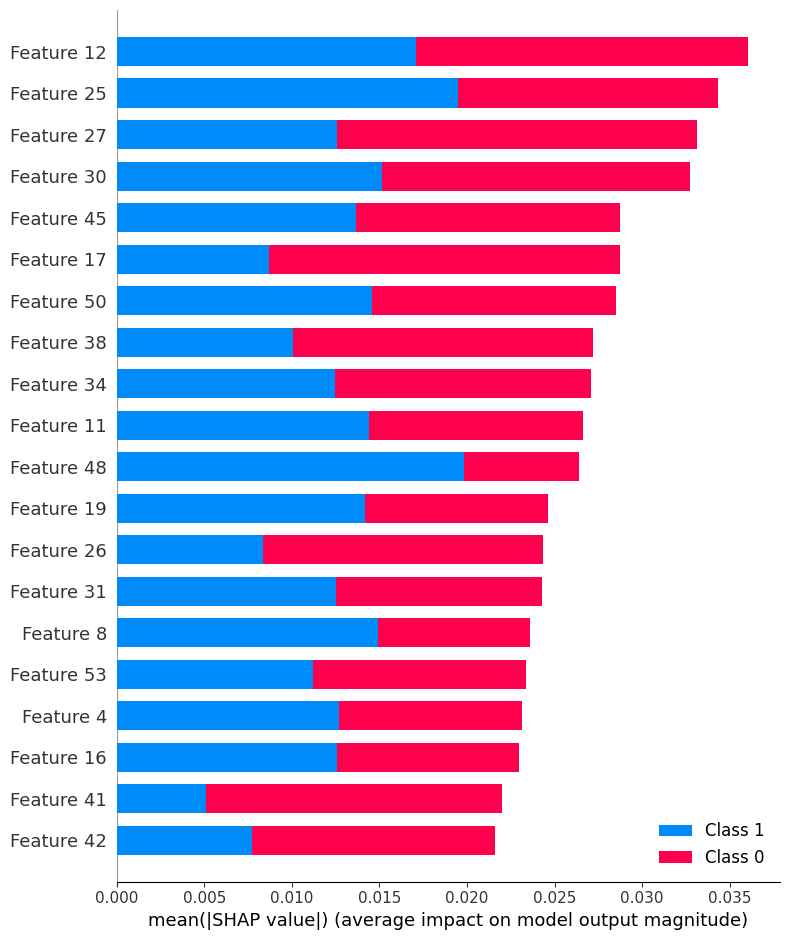

In [ ]:
import shap
import sklearn




X = torch.tensor(np.array([np.array(i[0]) for i in dataset])).to(DEVICE)
# X = DataLoader(dataset, batch_size=48, shuffle=True)

print(X[0])
print(model)

explainer = shap.DeepExplainer(model, X)
shap_values = explainer.shap_values(X)

print(shap_values[0].shape)
print(shap_values[1].shape)

# visualize the first prediction's explanation
# shap.plots.waterfall(shap_values[0])
shap.summary_plot(shap_values)